In [144]:
import ee
import numpy as np
import geopandas as gpd
import pandas as pd
import shapely
import glob
import os
from shapely.geometry import Polygon
from shapely.geometry import box
import matplotlib
import matplotlib.pyplot as plt

In [3]:
ee.Authenticate()

Enter verification code:  4/1AbUR2VP6rgBkmmibWixM5qKExfShvMCIVd93TmPlLbgunIgHpBZX8fpz9ho



Successfully saved authorization token.


In [5]:
from ee_download import download_image_by_asset_path, Curler

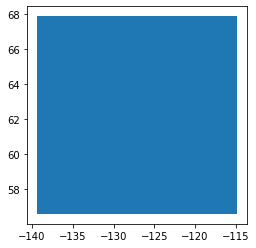

In [78]:
# create bbox

xmin = -139.3936913514372
ymin = 56.57864833838931
xmax = -114.82728842468266
ymax = 67.87397926052299


footprint = box(xmin, ymin, xmax, ymax)

poly = gpd.GeoDataFrame(pd.DataFrame(['box'], columns = ['geometry']),crs ='epsg:4326',geometry = [footprint])
poly.plot()
poly.to_file('/projects/Developer/icesat2_boreal/notebooks/radar_integration/Data/test_footprint.gpkg', driver='GPKG')


In [79]:
# import poly as if you have the data

gdf = gpd.read_file('/projects/Developer/icesat2_boreal/notebooks/radar_integration/Data/test_footprint.gpkg', crs='EPSG:4326')

In [80]:
gdf.bounds

,minx,miny,maxx,maxy
0,-139.393691,56.578648,-114.827288,67.873979


In [81]:
# make sub-footprint
cols = 91153
rows = 41812

minx = gdf.bounds.iloc[:,0][0]
miny = gdf.bounds.iloc[:,1][0]
maxx = gdf.bounds.iloc[:,2][0]
maxy = gdf.bounds.iloc[:,3][0]

In [82]:
minx, miny, maxx, maxy

(-139.3936913514372, 56.57864833838931, -114.82728842468266, 67.87397926052299)

In [104]:
sub_ftprint_nCols= (abs(minx - maxx)/91153)*10000
sub_ftprint_maxx = minx + sub_ftprint_nCols
sub_ftprint_maxx

-136.69861791153346

In [105]:
sub_ftprint_nRows = (abs(miny - maxy)/41812)*10000
sub_ftprint_maxy = miny + sub_ftprint_nRows
sub_ftprint_maxy

59.28010507859157

In [106]:
sub_ftprint_bbox = box(minx, miny, sub_ftprint_maxx, sub_ftprint_maxy)

In [107]:
sub_ftprint_bbox = gpd.GeoDataFrame(pd.DataFrame(['box'], columns = ['geometry']),crs ='epsg:4326',geometry = [sub_ftprint_bbox])



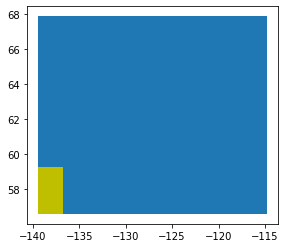

In [108]:
fig, ax = plt.subplots(1, 1)
gdf.plot(ax=ax)
sub_ftprint_bbox.plot(ax=ax, facecolor='y')

In [ ]:
# This will download all the tiles we need each to a zip, 
# the files inside are all named the same so next step is to overwrite that with the zip name

bbox_list = [sub_ftprint_bbox.bounds.iloc[:,0][0],sub_ftprint_bbox.bounds.iloc[:,1][0],sub_ftprint_bbox.bounds.iloc[:,2][0],sub_ftprint_bbox.bounds.iloc[:,3][0]]
bbox_list
gee_geom = ee.Geometry.Rectangle(bbox_list)
print(gee_geom)
    
downloaded_images = download_image_by_asset_path(
    asset_path = "projects/ee-foreststructure-above/assets/s1_vh_asc_pwr_frzn",
    output_folder = "/projects/Developer/icesat2_boreal/notebooks/radar_integration/",
    #region = gee_geom,
    #idx = str('test_file')
    )

# Test download of GEE asset in custom Albers projection
Paul Montesano  
June 22 2023

#### GEE asset vector tiles

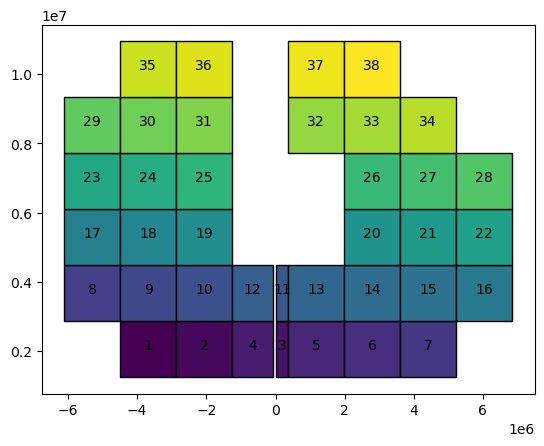

In [127]:
agg_tiles_gdf = gpd.read_file('/projects/shared-buckets/montesano/databank/boreal_tiles_v003_agg18.gpkg')
agg_tiles_gdf.plot(ec='black', column='agg_tile_num')
agg_tiles_gdf.boundary.plot(ax=ax, ec='black', alpha = 0.25)

agg_tiles_gdf['coords'] = agg_tiles_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
agg_tiles_gdf['coords'] = [coords[0] for coords in agg_tiles_gdf['coords']]

text = [ plt.annotate(text=row['agg_tile_num'], xy=row['coords'],horizontalalignment='center') for idx, row in agg_tiles_gdf.iterrows() ]

#### Get bounds of first tile in gdf

In [128]:
TILE_ID = 19

In [129]:
minx, miny, maxx, maxy = agg_tiles_gdf.bounds.iloc[TILE_ID - 1].to_list()

To downoad images in a collection, the pixel dims need be 32768 or less

In [130]:
# make subtile geom
npix = 32768

In [131]:
ncols= (abs(minx - maxx)/npix)*1e4
sub_bbox_maxx = minx + ncols
sub_bbox_maxx

-2377093.2343750056

In [132]:
nrows = (abs(miny - maxy)/npix)*1e4
sub_bbox_maxy = miny + nrows
sub_bbox_maxy

4967688.765625009

<AxesSubplot:>

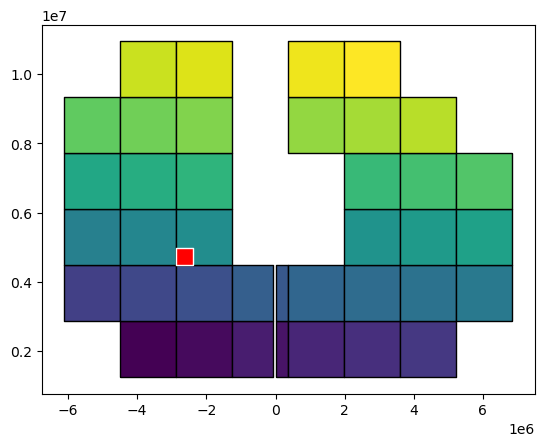

In [149]:
ax = agg_tiles_gdf.plot(ec='black', column='agg_tile_num')

bbox_geom = box(minx, miny, sub_bbox_maxx, sub_bbox_maxy)
bbox_gdf = gpd.GeoDataFrame(geometry = [bbox_geom], crs = agg_tiles_gdf.crs)

bbox_gdf.plot(ax = ax, facecolor='red', ec='white', figsize=(2,2))

## Get paths of the images in the image collection of our SAR stacks in GEE

In [118]:
import sys
sys.path.append('/projects/code/icesat2_boreal/notebooks/radar_integration')
import ee_download

In [137]:
COLL_ID = "projects/foreststructure/Circumboreal/S1_Composites_albers"
OUTDIR = "/projects/my-public-bucket/databank/s1_composites"

collection = ee.ImageCollection( COLL_ID)
collection_items = collection.toList(1000).getInfo()
collection_items_df = pd.DataFrame.from_dict(collection_items)
image_asset_path_list = collection_items_df.id.to_list()
image_asset_path_list

['projects/foreststructure/Circumboreal/S1_Composites_albers/s1_vv_vh_gamma_2018_pwr_tile19',
 'projects/foreststructure/Circumboreal/S1_Composites_albers/s1_vv_vh_gamma_2018_pwr_tile20',
 'projects/foreststructure/Circumboreal/S1_Composites_albers/s1_vv_vh_gamma_2018_pwr_tile26']

In [95]:
#downloaded_images = ee_download.download_images_in_collection(COLL_ID, OUTDIR, max_items=100)

In [119]:
# This will download all the tiles we need each to a zip, 
# the files inside are all named the same so next step is to overwrite that with the zip name

bbox_list = list(bbox_gdf.total_bounds)
bbox_list
gee_geom = ee.Geometry.Rectangle(bbox_list)
print(gee_geom)

for image_asset_path in image_asset_path_list:
    
    downloaded_image = ee_download.download_image_by_asset_path(
        asset_path = image_asset_path,
        output_folder = OUTDIR,
        region = gee_geom
        )

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -2871478.0000000056,
              4967688.765625009
            ],
            [
              -2871478.0000000056,
              4473304.000000009
            ],
            [
              -2377093.2343750056,
              4473304.000000009
            ],
            [
              -2377093.2343750056,
              4967688.765625009
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})


EEException: Unable to export unbounded image.